# YOLOv3 실습

**사전준비**

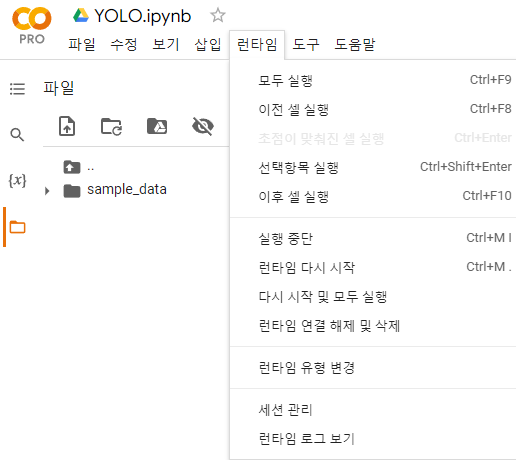
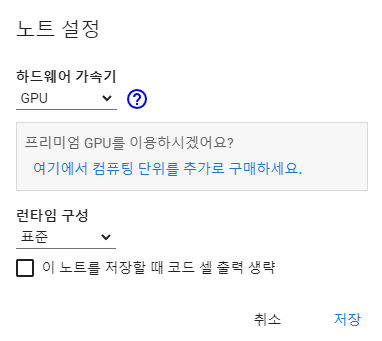

- colab 위쪽의 런타임 탭을 선택
- 런타임 유형 변경 선택
- 하드웨어 가속기를 gpu로 선택 하고 저장

**사용할 패키지 불러오기**

In [ ]:
import pandas as pd 
import numpy as np
import cv2 
import torch 
import os 
import time 
import random
from tqdm.auto import tqdm
import shutil as sh
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image, ImageDraw
import random
import warnings
from glob import glob 
import cv2
import json
from imageio import imread
from google.colab.patches import cv2_imshow
warnings.filterwarnings('ignore')

&nbsp;

## YOLO v3 ship_detection 실습


### YOLO v3 및 데이터 준비

- yolo v3 준비

In [ ]:
!git clone https://github.com/ultralytics/yolov3
%cd yolov3
!pip install -r requirements.txt

Cloning into 'yolov3'...
remote: Enumerating objects: 10058, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 10058 (delta 19), reused 28 (delta 13), pack-reused 10017
Receiving objects: 100% (10058/10058), 9.37 MiB | 15.01 MiB/s, done.
Resolving deltas: 100% (6777/6777), done.
/content/yolov3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 5.3 MB/s 


&nbsp;

- 데이터 준비 ([데이터 정보](https://www.kaggle.com/c/airbus-ship-detection))

In [ ]:
# 위치를 /content로 이동
%cd ..

# ship Object Detection 데이터셋 다운
!gdown https://drive.google.com/uc?id=1LwLwl-T4ShmcDLIDbnAch4OZMqfmk_67

# 압축 풀기
!unzip -qq "/content/ship_rle_coco.zip"

/content
Downloading...
From: https://drive.google.com/uc?id=1LwLwl-T4ShmcDLIDbnAch4OZMqfmk_67
To: /content/ship_rle_coco.zip
100% 173M/173M [00:00<00:00, 218MB/s]


- train : test 데이터 확인

In [ ]:
train_dir = glob('./ship_rle_coco/train/*.jpg')
test_dir = glob('./ship_rle_coco/test/*.jpg')

print(f'train 이미지 수 : {len(train_dir)}, test 이미지 수 : {len(test_dir)}')

train 이미지 수 : 301, test 이미지 수 : 100


&nbsp;

### coco 데이터의 annotations bbox 추출


**coco 데이터는 아래와 같은 특성이 존재**
```
{
    "categories": [   # categories는 사용하는 class의 내용을 기록
        {
            "id": 0,
            "name": "ship",
            "supercategory": "ship"
        }
    ],
    "images": [  # images 이미지의 file명, width, height 기록
        {
            "id": 0,
            "file_name": "thumbnail-ba5c72edb320b49a69e86b05775c49b2-scaled-1_jpeg.rf.035d587add7bc2a6c7616d72e56bfad4.jpg",
            "height": 416,
            "width": 416,
            "date_captured": "2020-05-11T04:28:59+00:00"
        },

    ],
    "annotations": [ # image_id 해당하는 이미지 번호, bbox에 bounding box 좌표 기록
        {
            "id": 0,
            "image_id": 0,
            "category_id": 2,
            "bbox": [
                253,
                120,
                16,
                21
            ],
            "area": 336,
            "segmentation": [],
            "iscrowd": 0
        },
      ]
}
```

- coco data 불러오기

In [ ]:
with open('./ship_rle_coco/coco_train.json', "r") as json_file:
    json_data = json.load(json_file)

- coco 데이터 DataFrame에 저장
  - yolov3 format 순서인 'classes','x_center','y_center','w','h' 로 변경하기 위해 annotations 의 bbox 데이터 가져오기

In [ ]:
image_list = {}  # 이미지 고유 번호를 위해 생성한 dict
for i in json_data['images']:
    image_list[i['id']] = i['file_name']


box_df = pd.DataFrame()
img_list = []
x_min_list = []
x_max_list = []
y_min_list = []
y_max_list = []

for i in json_data['annotations']:

    x_min,x_max,y_min,y_max = i['bbox']
    img_list.append(image_list[i['image_id']])
    x_min_list.append(x_min)
    x_max_list.append(x_max)
    y_min_list.append(y_min)
    y_max_list.append(y_max)


box_df['image'] = img_list
box_df['xmin'] = x_min_list
box_df['xmax'] = x_max_list
box_df['ymin'] = y_min_list
box_df['ymax'] = y_max_list

### yolov3 format으로 변환

In [ ]:
img_h, img_w = json_data['images'][0]['height'], json_data['images'][0]['width']

# x_center 생성
box_df['x_center'] = (box_df['xmin'] + box_df['xmax'])/2
box_df['x_center'] = box_df['x_center']/img_w

# y_center 생성
box_df['y_center'] = (box_df['ymin'] + box_df['ymax'])/2
box_df['y_center'] = box_df['y_center']/img_h

# width 생성
box_df['w'] = box_df['xmax'] - box_df['xmin']
box_df['w'] = box_df['w']/img_w

# height 생성
box_df['h'] = box_df['ymax'] - box_df['ymin']
box_df['h'] = box_df['h']/img_h

# class 생성
box_df['classes'] = 0

box_df.head()

image  xmin  xmax  ymin  ymax  x_center  y_center         w  \
0  000155de5.jpg   344   448   465   501  0.515625  0.628906  0.135417   
1  000194a2d.jpg   469   492   287   307  0.625651  0.386719  0.029948   
2  000194a2d.jpg    67    85   377   386  0.098958  0.496745  0.023438   
3  000194a2d.jpg   258   306   174   185  0.367188  0.233724  0.062500   
4  000194a2d.jpg    72    79   386   387  0.098307  0.503255  0.009115   

          h  classes  
0  0.046875        0  
1  0.026042        0  
2  0.011719        0  
3  0.014323        0  
4  0.001302        0

- 데이터 시각화

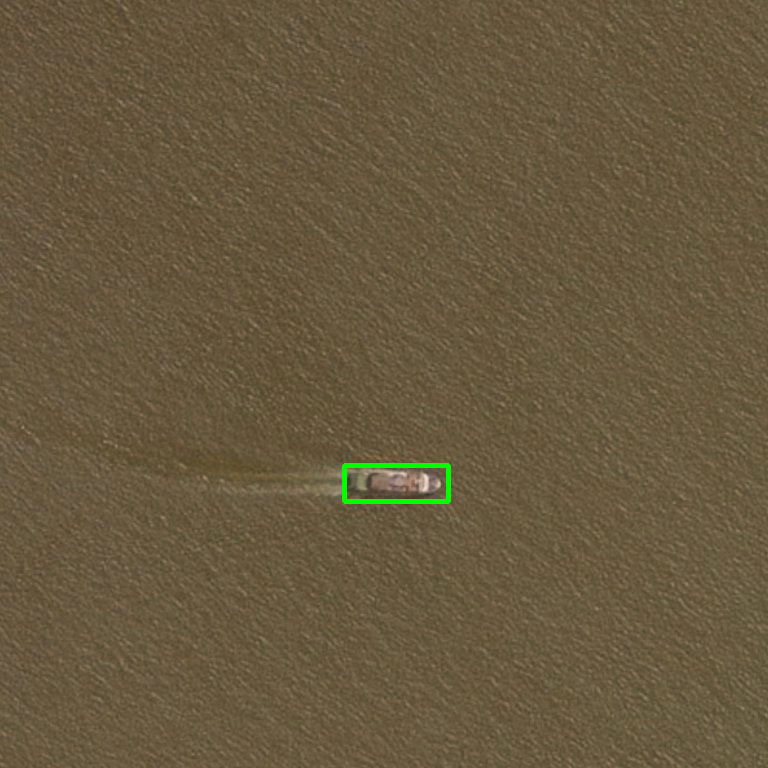

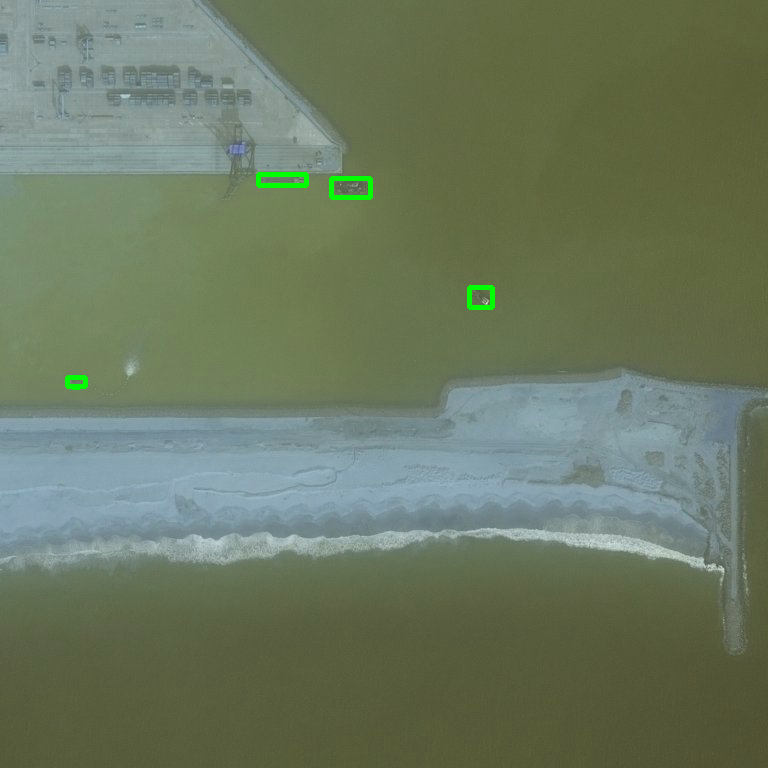

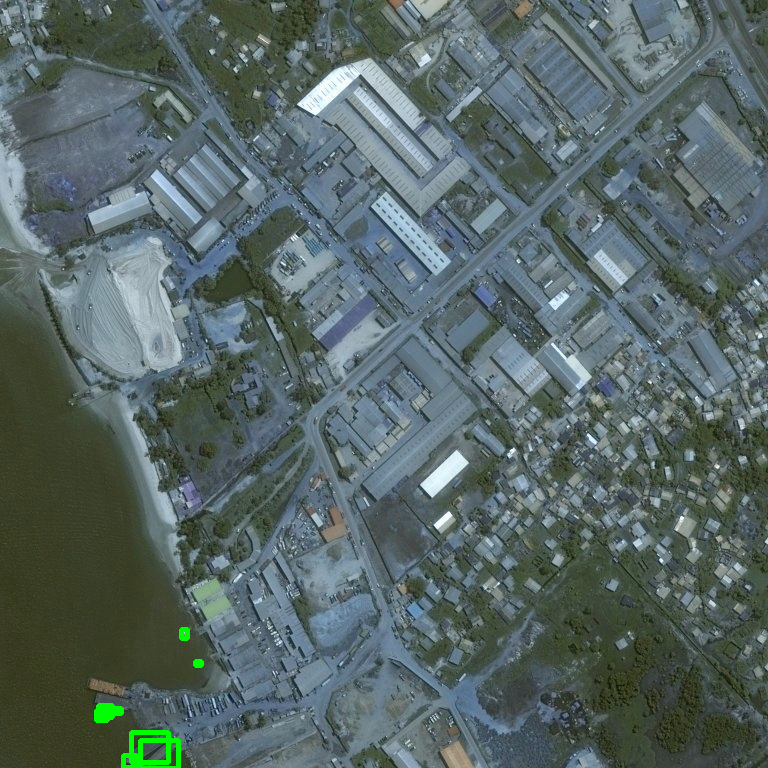

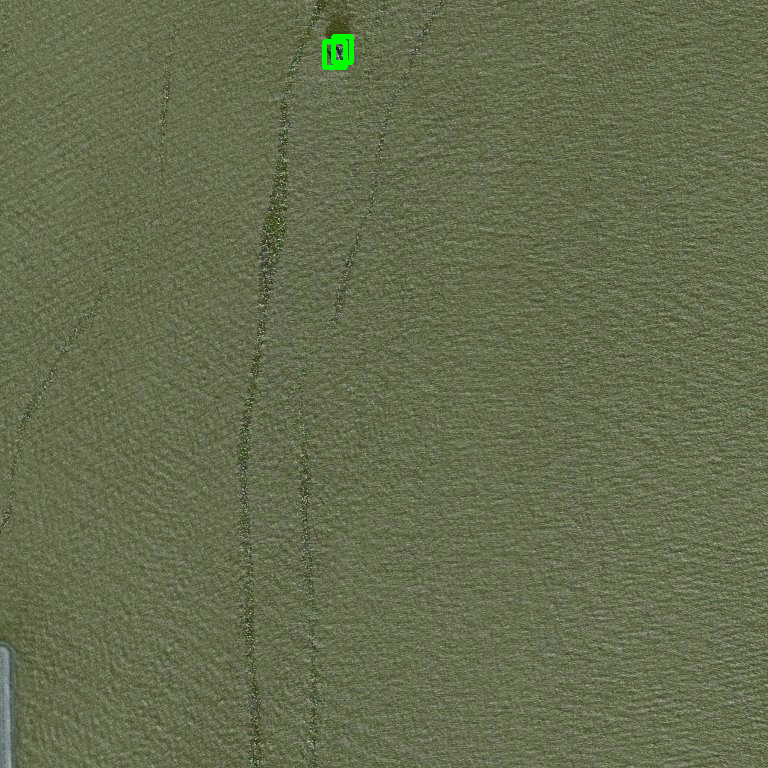

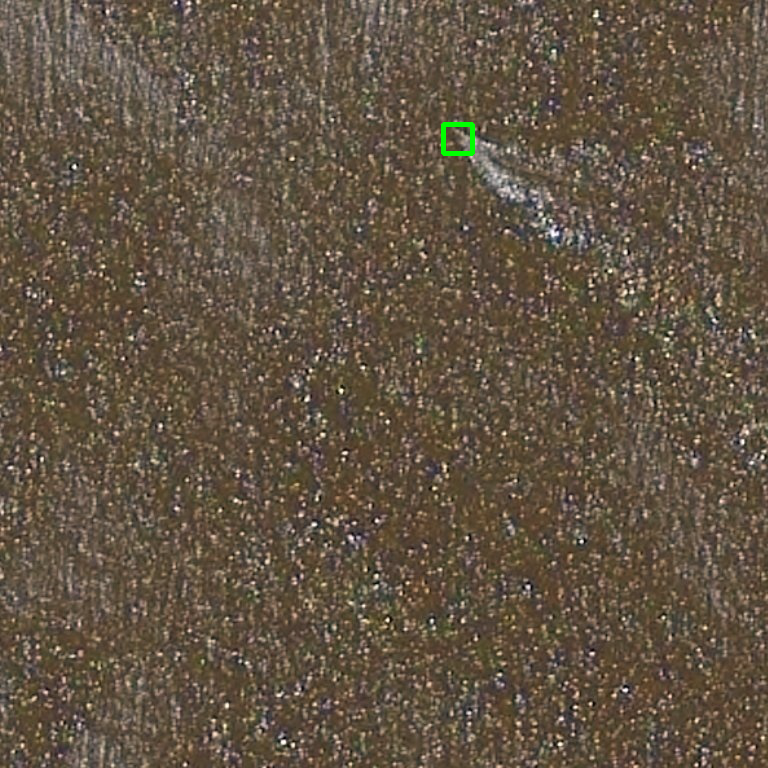

In [ ]:
cnt = 0

for i,d in box_df.groupby('image'):
  if cnt == 5:
    break
  else:
    img = imread(f'./ship_rle_coco/train/{i}')
    
    for num in range(len(d)):
      xmin,xmax,ymin,ymax = d.iloc[num][['xmin', 'xmax', 'ymin', 'ymax']]
      cv2.rectangle(img,(xmin,ymin),(xmax,ymax),(0,255,0),3)

    cv2_imshow(img)
    cnt +=1

### yolov3 폴더 형식 및 데이터 분할

 ─────────────────────────────────────────────────────────────    
 📁 yolov3_ship_data


   ├────📃 data.yaml : 데이터의 경로 및 class 내용이 담긴 yaml 파일


   ├──📁 images : tarin,val,test 이미지가 들어있는 폴더


   │    ├──📁 train     


   │    ├──📁 val 


   │    └──📁 test


   │    


   ├──📁 labels : tarin,val label이 들어있는 폴더


   │    ├──📁 train      


   │    └──📁 val 
─────────────────────────────────────────────────────────────      

In [ ]:
def make_dir():
    if not os.path.exists('./yolov3_ship_data'):
        os.makedirs('./yolov3_ship_data')

    if not os.path.exists('./yolov3_ship_data/images/'):
        os.makedirs('./yolov3_ship_data/images/')

    if not os.path.exists('./yolov3_ship_data/labels/'):
        os.makedirs('./yolov3_ship_data/labels/')

    for i in ['train','val']:
        if not os.path.exists(f'./yolov3_ship_data/images/{i}/'):
            os.makedirs(f'./yolov3_ship_data/images/{i}/')
        if not os.path.exists(f'./yolov3_ship_data/labels/{i}/'):
            os.makedirs(f'./yolov3_ship_data/labels/{i}/')

# 경로 생성
make_dir()

- 데이터 분할

In [ ]:
# box_df 중 train : valid 분리
split_data = list(set(list(box_df['image'])))
train_valid_split = random.sample(split_data, k= 210)


for name,sep in tqdm(box_df.groupby('image')):
    if name in train_valid_split:
        folder = 'train'
    else:
        folder = 'val'

    with open(f'./yolov3_ship_data/labels/{folder}/{name.split(".")[0]}.txt', 'w+') as f:
        # 실제 yolov3 format에 사용되는 class, x_center, y_center, width, height 만 남기기
        row = sep[['classes','x_center','y_center','w','h']].astype(float).values
        row = row.astype(str)
        for j in range(len(row)):
            text = ' '.join(row[j])
            f.write(text)
            f.write("\n")

    sh.copy(f"./ship_rle_coco/train/{name}", f'./yolov3_ship_data/images/{folder}/{name}')

  0%|          | 0/301 [00:00<?, ?it/s]

- test 데이터 옮기기

In [ ]:
test_imgs = [i.split('/')[-1] for i in glob('./ship_rle_coco/test/*.jpg')]

for i in tqdm(test_imgs):

    if not os.path.exists('./yolov3_ship_data/images/test/'):
        os.makedirs('./yolov3_ship_data/images/test/')

    sh.copy(f"./ship_rle_coco/test/{i}", f'./yolov3_ship_data/images/test/{i}')

  0%|          | 0/100 [00:00<?, ?it/s]

### yaml 파일 생성

In [ ]:
%%writefile ./yolov3_ship_data/data.yaml
train : ../yolov3_ship_data/images/train
val : ../yolov3_ship_data/images/val
test: ../yolov3_ship_data/images/test

nc : 1
names: [ship]

Writing ./yolov3_ship_data/data.yaml


### 모델 훈련

--batch : 한번에 훈련시킬 이미지 수 


--epochs : 훈련 횟수

--data : .yaml 경로

--weights : 사용할 모델 가중치, yolov3.py 입력시 자동으로 yolov3 가중치 다운 (연습에서는 사전에 학습시킨 모델 사용)


In [ ]:
os.chdir('./yolov3')
!python train.py --img 640 --batch 16 --epochs 5 --exist-ok --data  ../yolov3_ship_data/data.yaml --weights ../ship_rle_coco/best.pt --cache --device 0

train: weights=../ship_rle_coco/best.pt, cfg=, data=../yolov3_ship_data/data.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=5, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=0, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov3 ✅
YOLOv3 🚀 v9.6.0-27-gdd838e2 torch 1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0,

* 훈련 결과 출력 맨 아래줄에 **Results saved to** **경로**에 best.pt라는 이름으로 학습 가중치 가운데 validation score가 가장 좋은 결과가 저장됨

* 다음 셀의 --weights 인자에 위 **경로/best.pt**를 입력하여 저장된 가중치를 불러와 추론 수행

In [ ]:
!python ./detect.py --weights ./runs/train/exp/weights/best.pt --img 640 --conf 0.25 --line-thickness 1 --exist-ok --device 0 --source  ../yolov3_ship_data/images/test

detect: weights=['./runs/train/exp2/weights/best.pt'], source=../yolov3_ship_data/images/test, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=1, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv3 🚀 v9.6.0-27-gdd838e2 torch 1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model Summary: 261 layers, 61497430 parameters, 0 gradients, 154.5 GFLOPs
image 1/100 /content/yolov3_ship_data/images/test/000bd9dbf.jpg: 640x640 Done. (0.058s)
image 2/100 /content/yolov3_ship_data/images/test/00a3ab3cc.jpg: 640x640 3 ships, Done. (0.048s)
image 3/100 /content/yolov3_ship_data/images/test/00aa79c47.jpg: 640x640 5 ships, Done. (0.048s)
image 4/100 /content/yolov3_ship_data/images/test/00abc623a.jpg: 640x640 3 ships, Done. (0.038s)


### 모델 결과 시각화

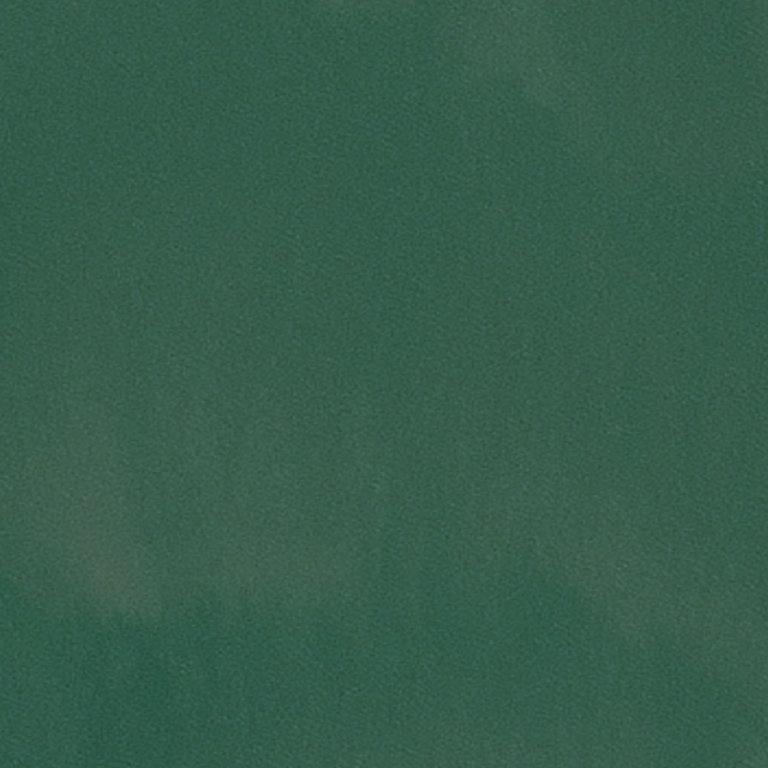

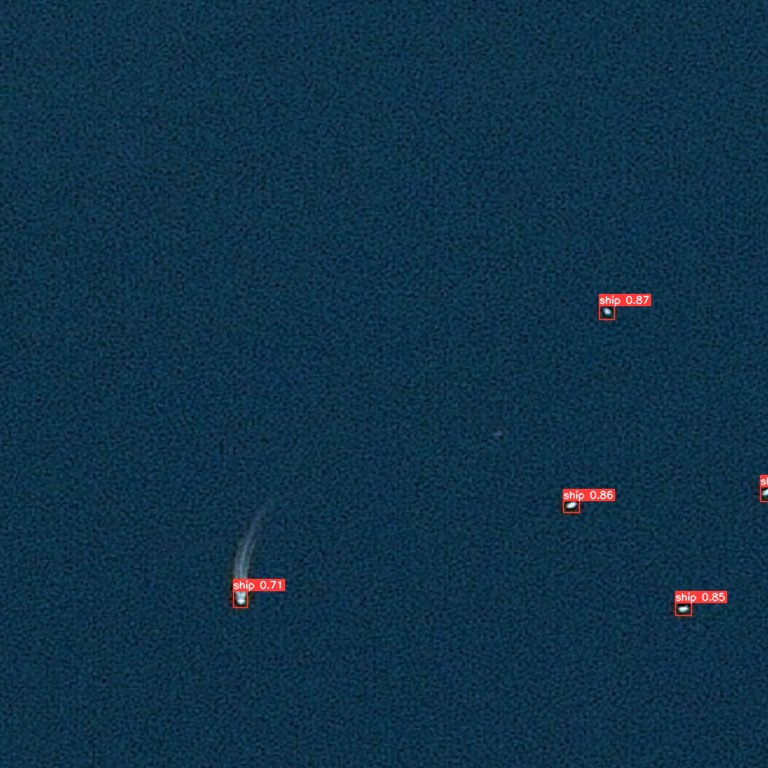

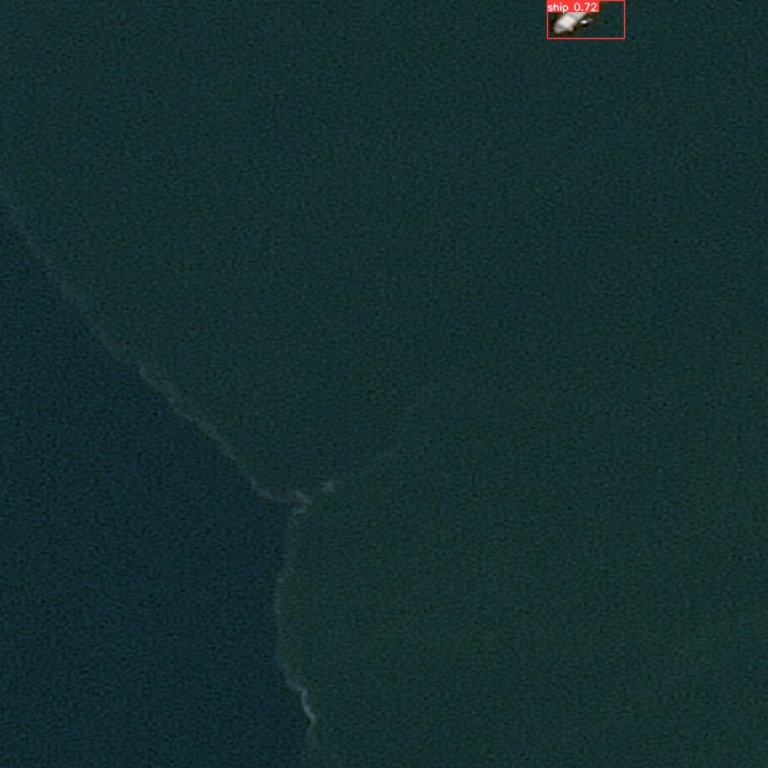

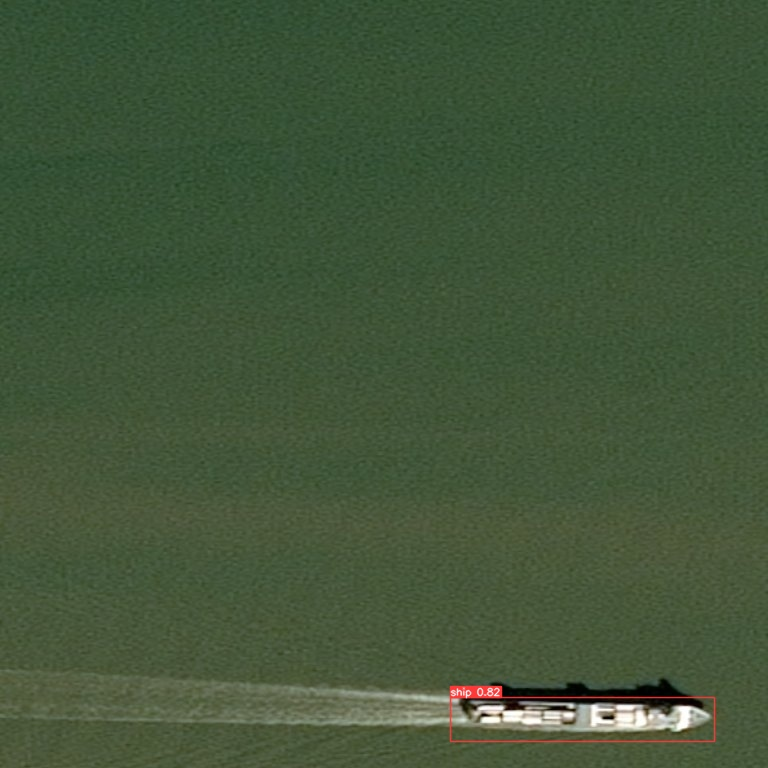

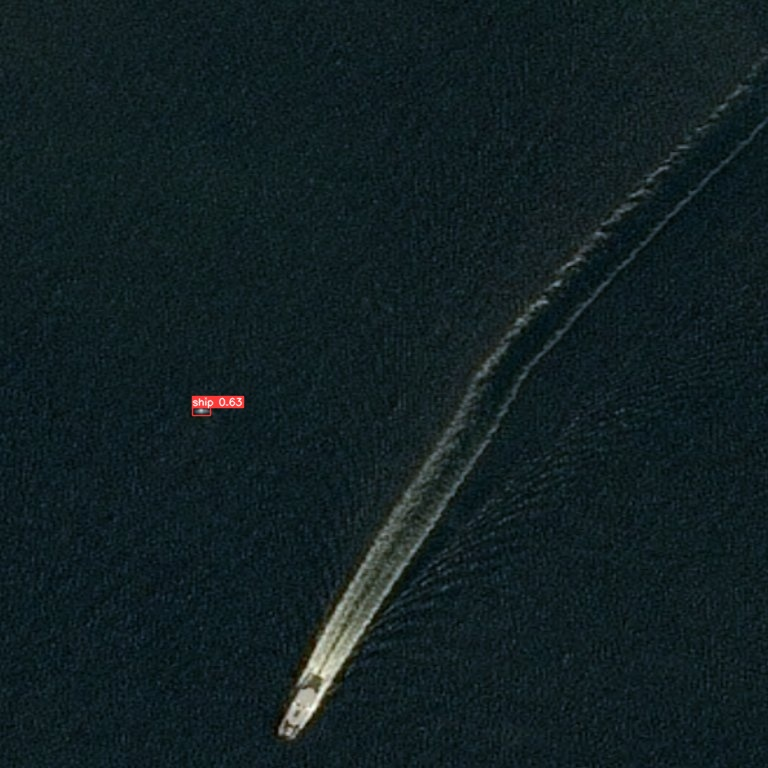

In [ ]:
data_list = glob('./runs/detect/exp/*.jpg')
random_img = random.sample(data_list, k=5)
for i in random_img:
  src = cv2.imread(i)

  cv2_imshow(src)